In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
from PIL import Image

In [3]:
# --- Load and preprocess images ---
def load_and_process_img(path_to_img):
    img = keras_image.load_img(path_to_img, target_size=(224, 224))
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

In [4]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    x = x.reshape((224, 224, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    return np.clip(x, 0, 255).astype('uint8')

In [5]:
# --- Compute content and style features ---
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
    outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
    return Model([vgg.input], outputs)

In [6]:


def get_feature_representations(model, content_path, style_path):
    content_img = load_and_process_img(content_path)
    style_img = load_and_process_img(style_path)
    style_outputs = model(style_img)
    content_outputs = model(content_img)
    style_features = [style_layer for style_layer in style_outputs[:5]]
    content_features = [content_outputs[5]]
    return style_features, content_features

In [7]:

# --- Loss functions ---
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    style_output_features = model_outputs[:5]
    content_output_features = model_outputs[5:]

    style_score = 0
    content_score = 0

    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += tf.reduce_mean(tf.square(gram_matrix(comb_style) - target_style))

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += tf.reduce_mean(tf.square(comb_content - target_content))

    style_score *= style_weight
    content_score *= content_weight
    loss = style_score + content_score
    return loss


In [8]:
# --- Optimization loop ---
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        loss = compute_loss(**cfg)
    return tape.gradient(loss, cfg['init_image']), loss

def run_style_transfer(content_path, style_path, num_iterations=1000,
                       content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    opt = tf.optimizers.Adam(learning_rate=5.0)
    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    for i in range(num_iterations):
        grads, loss = compute_grads(cfg)
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, -103.939, 255.0 - 103.939)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = init_image.numpy()

        if i % 100 == 0:
            print(f"Iteration {i}: loss={loss:.2f}")

    return deprocess_img(best_img)


In [11]:
content_path = "/content/jeremy-bishop-EwKXn5CapA4-unsplash.jpg"

In [12]:
# Create a plain gray style image
style_img = np.ones((224,224,3), dtype=np.uint8) * 128
Image.fromarray(style_img).save("/content/style.jpg")


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Iteration 0: loss=7480016896.00
Iteration 100: loss=23210808.00
Iteration 200: loss=9899177.00


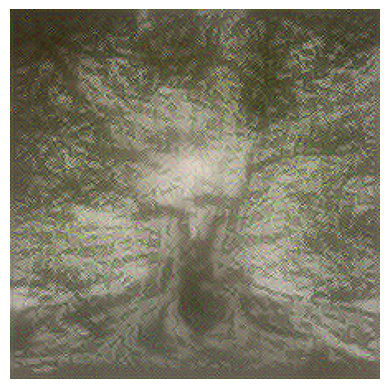

In [14]:
content_path = "/content/jeremy-bishop-EwKXn5CapA4-unsplash.jpg"
style_path = "/content/style.jpg"

stylized_image = run_style_transfer(
    content_path,
    style_path,
    num_iterations=300
)

plt.imshow(stylized_image)
plt.axis('off')
plt.show()
